# Análise da métrica "valor total aprovado" de um projeto cultural
---

Issues relacionadas ao estudo:
* [#69](https://github.com/lappis-unb/salic-ml/issues/69): Identificar outliers no total do valor aprovado do projeto
* [#169](https://github.com/lappis-unb/salic-ml/issues/169): Valor Aprovado - Evoluir notebook comparando Gaussiana com LOF

## Objetivos

Realizar uma análise comparativa entre o valor total aprovado de todos os projetos culturais de um mesmo **produto cultural**. Nesta análise, será investigado se o valor total aprovado de um projeto específico é anormal com relação aos demais projetos do mesmo produto cultural.

Para detectar anomalias/outliers serão utilizadas diversas estratégias, tanto de modelos de distribuição para aproximar a PDF (Probability Density Function) da RV (Random Variable) gerada pela métrica, quanto as baseadas em amostras, como é o caso do detector de outlier LOF (Local Outlier Factor).

Documentação relacionada: \[[link](https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira)\] Brainstorming de features para estimar a Complexidade Financeira

## Metodologia

Foram aplicados cinco modelos de detecção de anomalias: quatro baseados na aproximação da Função de Densidade de Probabilidade (PDF) e um baseado na exploração da densidade de amostras ao redor de um ponto específico (LOF). 

Para todos os modelos, a estratégia seguida foi a mesma. Primeiramente, dividiu-se o conjunto amostral em conjunto de treinamento (70% dos dados) e conjunto de teste (os 30% restantes dos dados).
Em seguida, cada um dos modelos foi treinado com o conjunto de treinamento, supondo uma taxa de contaminação fixa de 10% das amostras (contaminação é a taxa de outliers contidos na amostra).
O conjunto de testes foi passado a cada modelo, que retornou a relação de amostras rotuladas como inliers/outliers. Os tempos de treinamento e teste foram anotados e criou-se uma figura contendo dois histogramas, um para os inliers e um para os outliers.
Além disso, a métrica de contaminação encontrada foi levantada para comparar a eficiência de cada um dos cinco modelos.

#### Detecção de anomalias baseada na aproximação da PDF por modelos de distribuição

A PDF dos dados observados foi ajustada às seguintes distribuições:

* Distribuição Gaussiana;
* Distribuição Log-Normal;
* Distribuição Gamma;
* Estimação de Distribuição por Kernel Gaussiano (KDE).

O treinamento de todos os quatro modelos de distribuição consiste em ajustar a curva ao conjunto de treinamento e então encontrar, via bisseção, um limiar de densidade de probabilidade $p$, tal que, dada uma taxa de contaminação $c$, a igualdade abaixo é satisfeita:

$$ c = \int_{\forall x \ \vert \ f_X(x) < p}f_X(x)dx $$

Onde $f_X$ é a PDF encontrada ao ajustar cada uma das distribuições utilizadas.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta verificar se $f_X(x) \geq p$ ou $f_X(x) < p$, respectivamente, ou seja, $x$ é outlier se ele é pouco provável de acontecer, segundo a distribuição utilizada.

#### Detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico

O último modelo utilizado foi o _Local Outlier Factor_ (LOF), que verifica se uma amostra é um outlier ao comparar a densidade de amostras ao seu redor com a densidade de amostras de suas vizinhas. Caso uma amostra tenha densidade muito menor que suas vizinhas, ela é considerada um outlier.

O treinamento do LOF utiliza o `OutlierDetection` da classe `sklearn.neighbors.LocalOutlierFactor` para verificar quais são os outliers do conjunto de treinamento, passando a contaminação como parâmetro. Em seguida, os outliers são retirados do conjunto de treinamento e o LOF em si é treinado utilizando o `NoveltyDetection` da mesma classe.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta utilizar a função `predict` da `NoveltyDetection` para verificar se tal amostra tem uma densidade de amostras muito menor que a de sua vizinhança.

#### Validação da contaminação encontrada

Por fim, para avaliar de forma mais consistente a contaminação encontrada por cada um dos modelos utilizados, o procedimento de treino e teste foi repetido 100 vezes, sempre fixando a contaminação esperada em 10% e salvando a contaminação encontrada no conjunto de teste.

---
## Preparação

Será gerado um dataset contendo o valor total aprovado de um projeto, onde os projetos são identificados por seu PRONAC e produto cultural.

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.shape

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


(2026756, 25)

#### Visualizando produtos culturais

In [3]:
products = df[['idProduto', 'Produto', 'PRONAC']].drop_duplicates()
products = products.groupby(['idProduto', 'Produto']).count()
products = products.rename(columns={'PRONAC': 'numOccurrences'})
products = products.reset_index(level='Produto')
products = products.sort_values(by='numOccurrences', ascending=False)
print(products.shape)
products.head()

(75, 2)


,Produto,numOccurrences
idProduto,,
0,Administracao do Projeto,41568
19,Espetáculo de Artes Cênicas,10360
51,Apresentação Musical,8338
1,Livro,6476
18,Festival/Mostra,4944


#### Gerando tabela com o valor total de gastos aprovados por projeto e por segmento

In [4]:
approved_funds = df[['PRONAC', 'idProduto', 'VlTotalAprovado']]
approved_funds = approved_funds.groupby(['idProduto', 'PRONAC']).sum()
approved_funds.head()

VlTotalAprovado
idProduto PRONAC                 
0         90105         309580.00
          90226          52047.00
          90335         219980.00
          90413          33648.16
          90722          26856.12

---
## Desenvolvimento

Nesta etapa, analisaremos o valor total de gastos aprovado dos projetos para um produto cultural escolhido.

#### Esolhendo um produto cultural e gerando uma lista de valor total aprovado para todos os projetos do produto cultural

In [5]:
product = 19
projects = approved_funds.loc[product]['VlTotalAprovado']
print('Quantidade de projetos: %d' % len(projects))

# Gross rounding to improve visualization
print('Projetos com mais de 10M aprovado: %d' % sum(projects > 1e7))
projects[projects > 1e7] = 1e7

Quantidade de projetos: 10360
Projetos com mais de 10M aprovado: 35


#### Gerando histograma dos dados acima

Média da distribuição: 729679.68
Desvio padrão da distribuição: 1212643.63



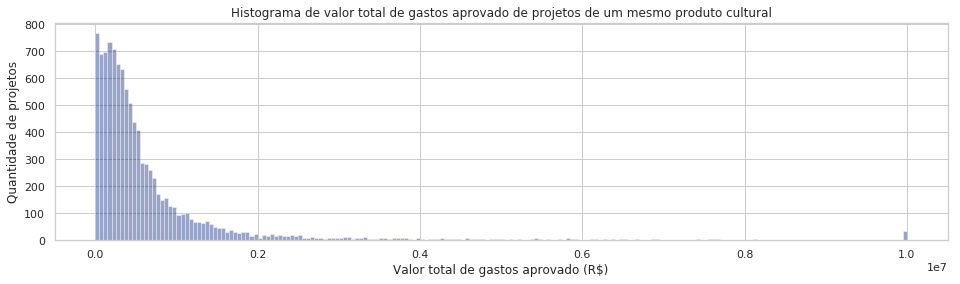

In [6]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(projects, bins=200, kde=False)
plt.title('Histograma de valor total de gastos aprovado de projetos de um mesmo produto cultural')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Valor total de gastos aprovado (R$)')
plt.grid(True)

expected_mean = np.mean(projects)
expected_std = np.std(projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [7]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
1410577    259960.0
1114524    403932.0
158748     294300.0
121208     275188.0
139185     962800.0
Name: VlTotalAprovado, dtype: float64

PRONAC
110146     394200.0
129317     202750.0
110773    1158495.0
150699     298530.0
111098     831610.0
Name: VlTotalAprovado, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [8]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        y = model.model.pdf(x)
        if hasattr(model, 'transform'):
            y = model.model.pdf(model.transform(x))
        plt.plot(x,  bin_size * len(test_set) * y, label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('approved funds (R$)')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [9]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.015 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 4.70%


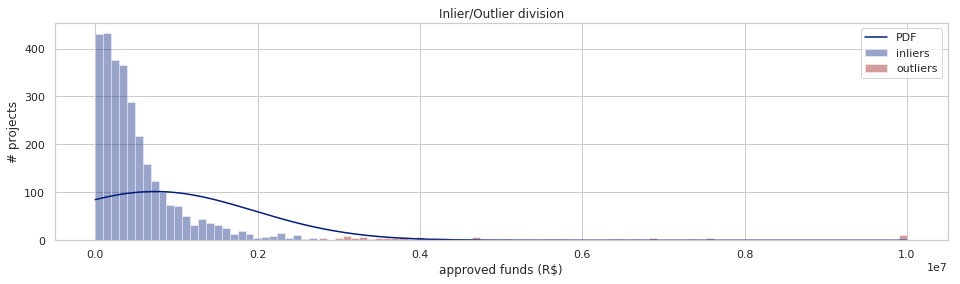

In [10]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=1e5)

#### Modelo Log-normal

Tempo de treinamento: 0.356 (s)
Tempo de teste: 0.004 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.59%


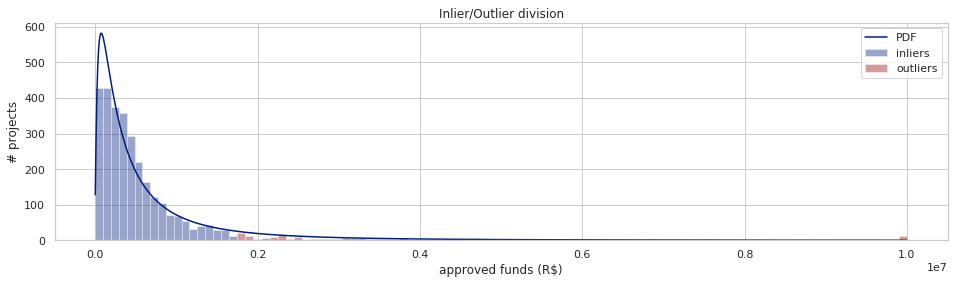

In [11]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(transform=lambda X: X+1e4), projects_train, projects_test, bin_size=1e5)

#### Modelo Gamma

Tempo de treinamento: 0.019 (s)
Tempo de teste: 0.003 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.69%


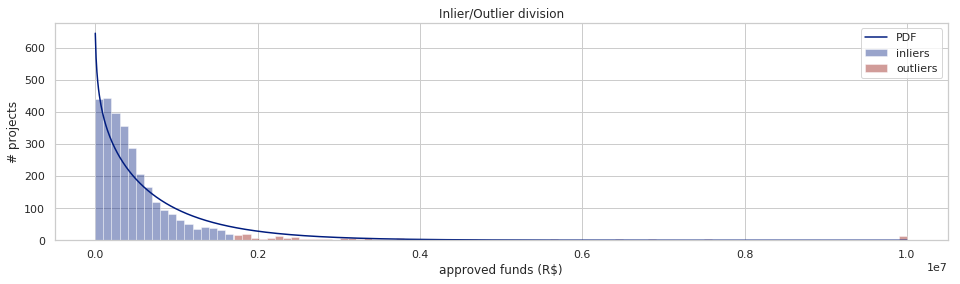

In [12]:
class Gamma:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(transform=lambda X: X+1e4), projects_train, projects_test, bin_size=1e5)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 1.142 (s)
Tempo de teste: 1.968 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 8.08%


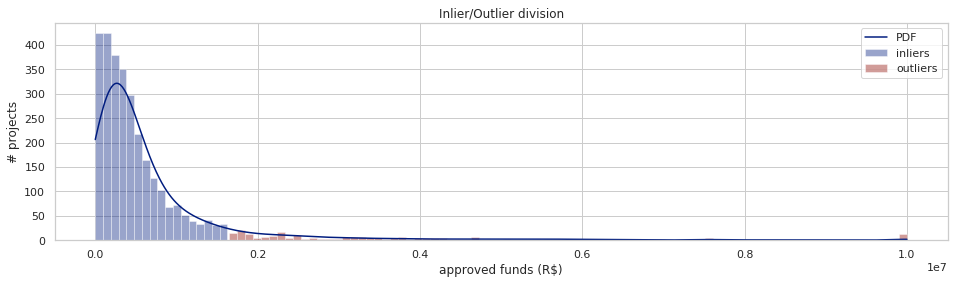

In [13]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=1e5)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 3.960 (s)
Tempo de teste: 0.027 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 19.53%


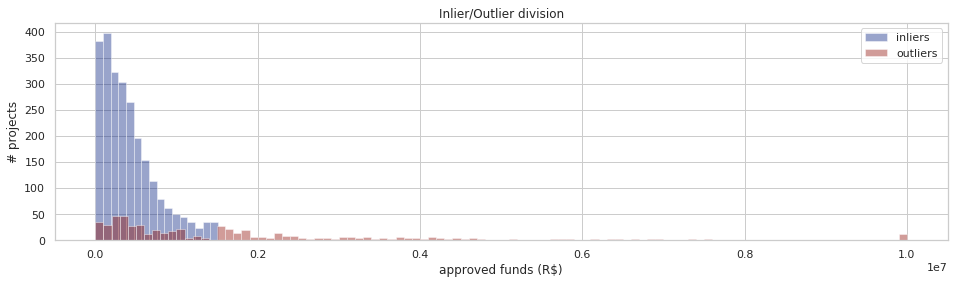

In [14]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=None):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        if self.n_neighbors == None:
            self.n_neighbors = len(X) // 5
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=self.contamination)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=1e5)

#### Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [16]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(transform=lambda X: X+1e4),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(transform=lambda X: X+1e4),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 4.74%
Média Log-normal: 8.26%
Média Gamma: 8.39%
Média KDE-Gauss: 8.85%
Média LOF: 21.53%


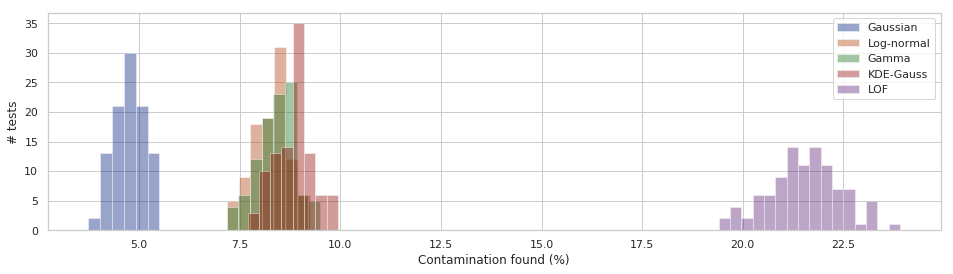

In [18]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.3
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados

Serão analisados os resultados com base nos seguinte critérios: tempo de execução de treino/teste, efetividade do modelo com relação à taxa de contaminação encontrada, e efetividade do modelo com relação a quais amostras foram rotuladas como outliers.

#### Tempo de execução de treino e teste

O modelo mais rápido, tanto para treinamento, quanto para teste, é o da Distribuição Gaussiana, gastando 15ms para o treinamento e apenas 2ms para o teste. Os modelos de Distribuição Log-Normal e Distribuição Gamma gastaram, respectivamente, 356ms e 19ms para treinamento e 4ms e 3ms para teste. Já os modelos LOF e de Distribuição KDE obtiveram os piores resultados com, respectivamente, 1142ms e 3960ms para treinamento e 1968ms e 27ms para teste.

#### Taxa de contaminação encontrada

Os resultados das 100 execuções de treino e teste realizadas mostram que os modelos de Distribuição Log-Normal, Gamma e KDE tiveram as melhores acurácias, ficando praticamente empatadas. Já a Distribuição Gaussiana detectou, em média, apenas a metade da contaminação esperada, devido às características de sua própria distribuição. O modelo LOF apresentou os piores resultados com, em média, 21.53% de outliers, sendo 10% o esperado.

#### Quais amostras foram rotuladas como outliers

Nos modelos de detecção de anomalias baseada na aproximação da PDF por modelos de distribuição, fica claro que os projetos rotulados como outliers têm valor muito abaixo ou muito acima da média, já o modelo de detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico, LOF, amostras com valores consideravelmente próximos à média da distribuição foram rotuladas como outliers, o que não parece fazer sentido para o contexto.

## Conclusões

Os modelos de Distribuição Log-Normal e Gamma apresentaram ótimos resultados e são as opções mais adequadas para a detecção de outliers no contexto, contudo, ambos os modelos necessitaram de um deslocamento no valor real dos dados, o que não influência na distância entre os valores, mas pode interferir no resultado final. O modelo KDE obteve bons resultados, contudo, não é uma boa opção, visto que ele demanda um tempo muito elevado de treino e teste. Os modelos menos adequados para o contexto são o Gaussiano, que obteve uma acurácia muito baixa, e o LOF, que obteve resultados ruins tanto em tempo de execução quanto em taxa de contaminação encontrada e quais amostras foram rotuladas como outliers.

#### Trabalhos futuros

Escolheu-se um produto cultural específo e todo o estudo foi realizado com base nos dados daquele produto cultural. Um trabalho futuro é a realização das mesmas análises e generalização para os outros produtos culturais.